# Quick Start Guide for the *TopicVI*

## Installation

To install the `TopicVI` package, you can folow these steps:

1. Install the `pytorch` package with the guidance from the [official PyTorch website](https://pytorch.org/get-started/locally/) based on your hardware and operating system. Noticed that your should install the `torch` package with the version of `2.0` or later.
2. Install the other required packages by running the following command in your terminal or command prompt:

   ```bash
   pip install -r requirements.txt
   ```
   
3. Install the `TopicVI` package by running the following command in your terminal or command prompt:

   ```bash
    pip install .
    ```

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import scvi
import topicvi as tv

c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\docrep\decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\docrep\decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


## Preprare the data

In [2]:
# achive the pbmc dataset
adata = scvi.data.pbmc_dataset()

INFO     Downloading file at data/gene_info_pbmc.csv                                                               
Downloading...: 909it [00:01, 776.05it/s]                            
INFO     Downloading file at data/pbmc_metadata.pickle                                                             
Downloading...: 4001it [00:03, 1025.95it/s]                            
INFO     Downloading file at data/pbmc8k\filtered_gene_bc_matrices.tar.gz                                          
Downloading...: 37559it [00:33, 1111.97it/s]                             
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc8k/filtered_gene_bc_matrices\GRCh38                                   
INFO     Downloading file at data/pbmc4k\filtered_gene_bc_matrices.tar.gz                                          
Downloading...: 100%|██████████| 18424/18424.0 [00:16<00:00, 1091.47it/s]
INFO     Extra

c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\scvi\data\_built_in_data\_pbmc.py:75: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = pbmc8k.concatenate(pbmc4k)


In [ ]:
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.filter_cells(adata, min_genes=1)
adata.var_names_make_unique()
adata.obs_names_make_unique()
adata.var.set_index('gene_symbols', inplace=True)

In [5]:
adata.obs['str_labels'].unique()

array(['CD4 T cells', 'CD14+ Monocytes', 'CD8 T cells', 'B cells',
       'Other', 'Dendritic Cells', 'FCGR3A+ Monocytes', 'NK cells',
       'Megakaryocytes'], dtype=object)

### preprocess the expression data

To minimize the memory usage, we recommend you to use `preprocess_adata` function in the `TopicVI` package to preprocess your data. 
This function will perform the following steps:
1. Calculate the size factor for each cell.
2. perform the quality control to remove the cells with low quality.
3. Normalize the data, and log-transform the data.
4. get HVGs (highly variable genes) based on the normalized data.
5. reconvert the count data to the original format.

In [6]:
adata = tv.pp.preprocess_adata(adata, batch_key="batch", nhvg=2000)

Total number of cells: 11990
Number of cells after filtering of low quality cells: 11746


### prepare the gene prior knowledge

In the `TopicVI` package, we provide a bunch of known gene sets.

In model, you should specify two kind of gene priors:
1. cluster specific gene prior, like cell type specific gene prior.
2. background gene prior, all others.

In [7]:
tv.prior.summary_of_builtin_priors()


        Summary of built-in priors:

        Cell Types Related:
        - CellMarkerDB. use `search_cellmarker_db` to search for cell markers.
        - ScTypeDB. use `search_sctype_db` to search for cell types.
        - Meta-Program. use `get_metaprogram` to get meta-programs.

        Common Used Annotations:
        (From Enrichr Database and MSigDB)
        use get_priors to get the gene sets, specify the source as below.
        - GO. (GOBP, GOMF, GOCC)
        - KEGG.
        - Reactome.
        - Hallmark.
        - Immune Related.
        - TF. 
        - Tissue. (Tissue specific gene sets from DAVID database)

        Others:
        - DEGenes. use `get_de_genes` to get differentially expressed genes.
        - Random. use `get_random_select_gs` to get random gene sets.
        


In [8]:
tv.prior.load_sctype_db()

,tissue_type,cell_type,positive_markers,negative_markers,cell_type_abbv
0,Immune system,Pro-B cells,"CD27,IgD,CD24,PTPRC,PAX5,CD24,CD38,CD79A,DNTT,...",NaN,Pro-B
1,Immune system,Pre-B cells,"CD19,CD27,IgD,CD24,PTPRC,PAX5,CD24,CD38,CD79A,...",NaN,Pre-B
2,Immune system,Naive B cells,"CD19,IgD,CD38,CD24,CD20,MS4A1,PTPRC,PAX5,CD24,...",NaN,Naive B
3,Immune system,Memory B cells,"CD19,CD27,IgD,CD38,CD24,CD20,MS4A1,PTPRC,PAX5,...",NaN,Memory B
4,Immune system,Plasma B cells,"CD27,IgD,CD38,CD24,CD20,MS4A1,PTPRC,PAX5,CD24,...","CD20,MS4A1",Plasma B
...,...,...,...,...,...
236,Eye,Cancer cells,EPCAM,NaN,Cancer
237,Lung,Cancer stem cells,"ABCG2,ALCAM,ALDH1A1,BMI1,CD24,CD44,KIT,NANOG,N...",NaN,CSCs
238,Brain,Cancer cells,"CD44,MBTPS2,PARP1",NaN,Cancer
239,Brain,Cancer stem cells,"FUT4,MSI1,NES,PROM1,SOX2,THY1",NaN,CSCs


In [9]:
cell_markers = tv.prior.search_sctype_db(
    cell_type = '', # use all cell types
    tissue_type='Immune system',
)

Loading cell type database
Searching for tissue type Immune system
Searching for cell type 


In [10]:
cellmarkerdb_search_result = tv.prior.search_cellmarker_db(
    cell_types=['B cell', 'T cell', 'Monocyte', 'NK'],
    tissue_type='Peripheral blood',
)

Searching for cell markers with tissue type Peripheral blood and cancer type Normal


In [11]:
# for background knowledge, here we use Hallmark and Reactome gene sets
background_genesets = {
    **tv.prior.get_priors('Hallmark'),
    **tv.prior.get_priors('Reactome'),
}

### Add the gene prior knowledge into adata

In [17]:
tv.prior.add_prior_to_adata(
    adata, background_prior=background_genesets,
    cluster_prior=cell_markers,
    cluster_min_genes=5,
    background_min_genes=10,
    key_added='annotation'
)

In [19]:
adata.write_h5ad('./results/tutorial_pbmc/adata.h5ad')

## Train the model

In [2]:
adata = sc.read_h5ad('./results/tutorial_pbmc/adata.h5ad')

In [30]:
adata

AnnData object with n_obs × n_vars = 11746 × 2000
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'n_genes', 'size_factor', 'default_cluster'
    var: 'n_counts-0', 'n_counts-1', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'annotation', 'cell_types', 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'design', 'normalized_qc', 'qc_pc', 'raw_qc'
    varm: 'PCs'
    layers: 'counts', 'normalized'

### Training in one step

In [31]:
config = tv.make_default_config(project_name='tutorial_pbmc', working_dir='./results/')
config['data_kwargs']['default_cluster_key'] = 'default_cluster'
config['data_kwargs']['batch_key'] = 'batch'
config['data_kwargs']['size_factor_key'] = 'size_factor'
config

{'data_kwargs': {'annotation_key': 'annotation',
  'batch_key': 'batch',
  'default_cluster_key': 'default_cluster',
  'size_factor_key': 'size_factor'},
 'description': 'this is a default config, please modify it if need',
 'extra_kwargs': {'topicvi': {'data_kwargs': {'label_key': None},
   'model_kwargs': {'cluster_decoder_params': {'center_penalty_weight': 1},
    'pretrain_kwargs': {'batch_size': 128,
     'early_stopping': True,
     'max_epochs': 1000,
     'plan_kwargs': {'lr': 0.001, 'reduce_lr_on_plateau': True}}},
   'train_kwargs': {'max_epochs': 1000,
    'plan_kwargs': {'cl_weight': 1},
    'pretrain_model': './results/tutorial_pbmc\\pretrain_model'}},
  'topicvi_denovo_finding': {'data_kwargs': {'label_key': None},
   'train_kwargs': {'pretrain_model': './results/tutorial_pbmc\\pretrain_model'}}},
 'model_kwargs': {'n_clusters': 10, 'n_topics': 32},
 'project_name': 'tutorial_pbmc',
 'save_dir': './results/tutorial_pbmc',
 'train_kwargs': {'batch_size': 1024,
  'early_sto

In [70]:
tv.utils.write_config(config, './results/tutorial_pbmc/config.yaml')

To initiate the cluster training process, we set the `default_cluster_key` in configuration file, and now we run the process by following code:

In [9]:
tv.model.run_default_cluster(adata, layer = 'counts', batch_key='batch', max_cells=2e5)

c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
2025-06-09 13:02:59,603 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-06-09 13:02:59,603 - Computing initial centroids with sklearn.KMeans...


2025-06-09 13:03:00,488 - harmonypy - INFO - sklearn.KMeans initialization complete.


2025-06-09 13:03:00,488 - sklearn.KMeans initialization complete.


2025-06-09 13:03:00,535 - harmonypy - INFO - Iteration 1 of 10


2025-06-09 13:03:00,535 - Iteration 1 of 10


2025-06-09 13:03:02,299 - harmonypy - INFO - Iteration 2 of 10


2025-06-09 13:03:02,299 - Iteration 2 of 10


2025-06-09 13:03:04,090 - harmonypy - INFO - Iteration 3 of 10


2025-06-09 13:03:04,090 - Iteration 3 of 10


2025-06-09 13:03:04,701 - harmonypy - INFO - Iteration 4 of 10


2025-06-09 13:03:04,701 - Iteration 4 of 10


2025-06-09 13:03:05,289 - harmonypy - INFO - Iteration 5 of 10


2025-06-09 13:03:05,289 - Iteration 5 of 10


2025-06-09 13:03:07,174 - harmonypy - INFO - Iteration 6 of 10


2025-06-09 13:03:07,174 - Iteration 6 of 10


2025-06-09 13:03:07,777 - harmonypy - INFO - Converged after 6 iterations


2025-06-09 13:03:07,777 - Converged after 6 iterations
Cluster for default_cluster_0.1 with leiden
resolution: 0.1, inverse_davies_bouldin_score: 0.6893958775655347
Cluster for default_cluster_0.2 with leiden
resolution: 0.2, inverse_davies_bouldin_score: 0.6392904553639157
Cluster for default_cluster_0.30000000000000004 with leiden
resolution: 0.30000000000000004, inverse_davies_bouldin_score: 0.5934891939533107
Cluster for default_cluster_0.4 with leiden
resolution: 0.4, inverse_davies_bouldin_score: 0.5279317952626994
Cluster for default_cluster_0.5 with leiden
resolution: 0.5, inverse_davies_bouldin_score: 0.5094809137093559
Cluster for default_cluster_0.6 with leiden
resolution: 0.6, inverse_davies_bouldin_score: 0.4812182836305442
Cluster for default_cluster_0.7000000000000001 with leiden
resolution: 0.7000000000000001, inverse_davies_bouldin_score: 0.4818665994064204
Cluster for default_cluster_0.8 with leiden
resolution: 0.8, inverse_davies_bouldin_score: 0.48679599740633733
Cl

d:\Project\deepbicluster\topicvi\model\__init__.py:53: UserWarning: Overwriting existing key default_cluster in adata.obs
  scib.clustering.cluster_optimal_resolution(


In [32]:
tv.run_topicvi(
    adata, config, verbose=True, save_model=True,
)

INFO     No backup URL provided for missing file ./results/tutorial_pbmc\pretrain_model\model.pt                   


d:\Project\deepbicluster\topicvi\run.py:29: ResourceWarning: unclosed file <_io.TextIOWrapper name='d:\\Project\\deepbicluster\\results\\tutorial_pbmc\\topicvi\\log.txt' mode='a' encoding='utf-8'>
  logging.basicConfig(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No pretrained model found or something error occuredstart training from scratch. Failed to load model file at ./results/tutorial_pbmc\pretrain_model\model.pt. If attempting to load a saved model from <v0.15.0, please use the util function `convert_legacy_save` to convert to an updated format.
use the parameters for pretrain {'n_hidden': 128, 'n_latent': 32, 'n_layers': 2, 'dropout_rate': 0, 'dispersion': 'gene', 'gene_likelihood': 'zinb'}


c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 475/1000:  48%|####7     | 475/1000 [07:01<07:46,  1.13it/s, v_num=1, train_loss_step=608, train_loss_epoch=601]Monitored metric elbo_validation did not improve in the last 45 records. Best score: 646.872. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
c:\Users\CGX\.conda\envs\scvi\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 912/1000:  91%|#########1| 912/1000 [20:00<01:55,  1.32s/it, v_num=1, train_loss_step=4.79e+3, train_loss_epoch=4.78e+3]Monitored metric elbo_validation did not improve in the last 45 records. Best score: 25.990. Signaling Trainer to stop.


In [35]:
os.listdir('./results/tutorial_pbmc/')

['adata.h5ad', 'pretrain_model', 'topicvi']

## analyze the results

Directly get the results from the saved npz file.

In [ ]:
with open('./results/tutorial_pbmc/topicvi/results.npz', 'rb') as f:
    topicvi_results = np.load(f, allow_pickle=True)

In [ ]:
topicvi_results.keys()

KeysView(NpzFile 'object' with keys: loading, factors, embedding, labels)

Or you can analyze the results with the `TopicVI` model.

In [36]:
model = tv.TopicVI.load(
    './results/tutorial_pbmc/topicvi/model/',
    adata=adata,
) 

INFO     File ./results/tutorial_pbmc/topicvi/model/model.pt already downloaded                                    


In [39]:
model.store_topics_info()
adata.obsm['topicvi'] = model.get_latent_representation()
_ = model.get_cluster_assignment()

In [69]:
adata

AnnData object with n_obs × n_vars = 11746 × 2000
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'n_genes', 'size_factor', 'default_cluster', '_scvi_batch', '_scvi_labels_', '_scvi_labels', 'model_predict', 'leiden_topicvi'
    var: 'n_counts-0', 'n_counts-1', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'annotation', 'cell_types', 'hvg', 'log1p', 'pca', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden_topicvi', 'model_predict_colors', 'default_cluster_colors', 'leiden_topicvi_colors', 'str_labels_colors'
    obsm: 'X_pca', 'design', 'normalized_qc', 'qc_pc', 'raw_qc', 'topic_by_sample', 'topicvi', 'X_umap'
    varm: 'PCs', 'topic_by_gene'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [ ]:
sc.pp.neighbors(adata, use_rep="topicvi", knn=True, metric="euclidean",)
sc.tl.umap(adata,)
sc.tl.leiden(adata, resolution=0.3, key_added="leiden_topicvi")

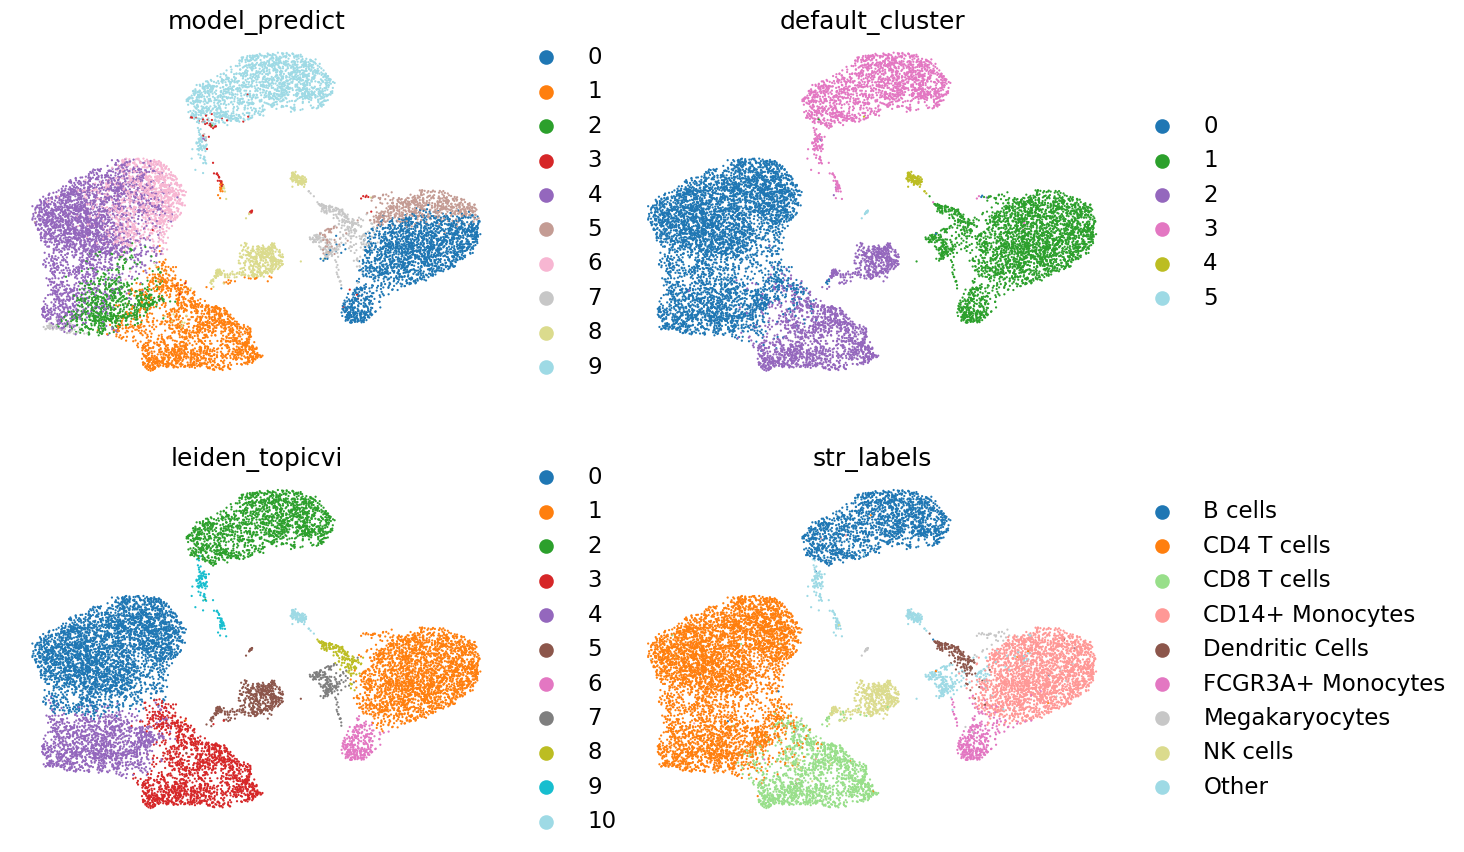

In [52]:
sc.pl.umap(
    adata,
    color=['model_predict', 'default_cluster', 'leiden_topicvi', 'str_labels'],
    frameon=False, palette="tab20", cmap="RdBu_r",
    ncols=2,
    # save = 'umaps.pdf',
)

### Analyze the topics

In [59]:
# store the topic loading as a new data
fdata = model.get_topic_combined_data()
fdata

AnnData object with n_obs × n_vars = 11746 × 32
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'n_genes', 'size_factor', 'default_cluster', '_scvi_batch', '_scvi_labels_', '_scvi_labels', 'model_predict', 'leiden_topicvi'
    var: 'ISG15', 'PANK4', 'KLHL21', 'PER3', 'CA6', 'CTNNBIP1', 'KIF1B', 'DFFA', 'FBXO2', 'PLOD1', 'TNFRSF8', 'TNFRSF1B', 'DHRS3', 'EFHD2', 'ATP13A2', 'PADI2', 'CDA', 'C1QA', 'C1QB', 'ID3', 'GALE', 'FUCA1', 'CNR2', 'ZNF593', 'SH3BGRL3', 'DHDDS', 'HMGN2', 'RPS6KA1', 'ZDHHC18', 'SLC9A1', 'MAP3K6', 'FGR', 'IFI6', 'FAM76A', 'EYA3', 'PHACTR4', 'GMEB1', 'MECR', 'TMEM39B', 'TXLNA', 'MARCKSL1', 'YARS', 'ZMYM1', 'KIAA0319L', 'CSF3R', 'SNIP1', 'FHL3', 'TRIT1', 'PPT1', 'COL9A2', 'HIVEP3', 'CDC20', 'HYI', 'DPH2', 'ATP6V0B', 'PTCH2', 'EIF2B3', 'TOE1', 'AKR1A1', 'IPP', 'MKNK1', 'ECHDC2', 'C1orf123', 'SSBP3', 'HOOK1', 'L1TD1', 'ALG6', 'ITGB3BP', 'PGM1', 'GADD45A', 'HHLA3', 'FPGT', 'CRYZ', 'AK5', 'IFI44L', 'GNG5', 'MCOLN3', 'BCL10', 'GBP2', 'TGFBR3', 'GFI1', 'GCLM', 'PTBP2', '

In [ ]:
topics = tv.TopicDict.transfer_from_adata(adata, topk=50) # get top 50 genes for each topic
priors1 = adata.uns['annotation']['background']
priors2 = adata.uns['annotation']['clusters']
topics.compare_prior_overlap(prior = {**priors1, **priors2})

In [71]:
topics[0]

Index(['GNG5', 'GNG11', 'GNG3', 'GNAI2', 'GNA15', 'SPHK1', 'PLCB3', 'ADCY7',
       'PRKAR2B', 'ZNF217', 'FKBP5', 'POU2F1', 'GTF2A1', 'CCNT1', 'EREG',
       'CARM1', 'NRAS', 'MYC', 'FOS', 'TBCC', 'HLTF', 'UCHL3', 'UBE2W', 'USP5',
       'FBXW7', 'MAPK3', 'TUBB6', 'CTR9', 'PAF1', 'UBE2Z', 'CDC34', 'BCL10',
       'TALDO1', 'ACSL4', 'AKAP5', 'PRKX', 'CAMK4', 'CDK5', 'PRKAB2', 'PRKCD',
       'DHRS9', 'DHRS3', 'AKR1C3', 'PDK4', 'SREBF1', 'MECR'],
      dtype='object', name='gene_symbols')

In [56]:
topics.get_topic_annotes(ntop=1)

[{'Signaling By Nuclear Receptors R-HSA-9006931': 0.4117647058823529},
 {'DNA Repair R-HSA-73894': 0.5483870967741935},
 {'Membrane Trafficking R-HSA-199991': 0.34782608695652173},
 {'Organelle Biogenesis And Maintenance R-HSA-1852241': 0.6764705882352942},
 {'Intra-Golgi And Retrograde Golgi-to-ER Traffic R-HSA-6811442': 0.4716981132075472},
 {'RHO GTPase Cycle R-HSA-9012999': 0.8490566037735849},
 {'KEAP1-NFE2L2 Pathway R-HSA-9755511': 0.21818181818181817},
 {'SLC Transporter Disorders R-HSA-5619102': 0.3076923076923077},
 {'S Phase R-HSA-69242': 0.8260869565217391},
 {'Toll-like Receptor Cascades R-HSA-168898': 0.5714285714285714},
 {'Plasmacytoid Dendritic cells': 0.8181818181818182},
 {'Regulation Of Lipid Metabolism By PPARalpha R-HSA-400206': 0.6666666666666666},
 {'HIV Infection R-HSA-162906': 0.8611111111111112},
 {'C-type Lectin Receptors (CLRs) R-HSA-5621481': 0.5151515151515151},
 {'Phospholipid Metabolism R-HSA-1483257': 0.46153846153846156},
 {'Mitochondrial Translation R

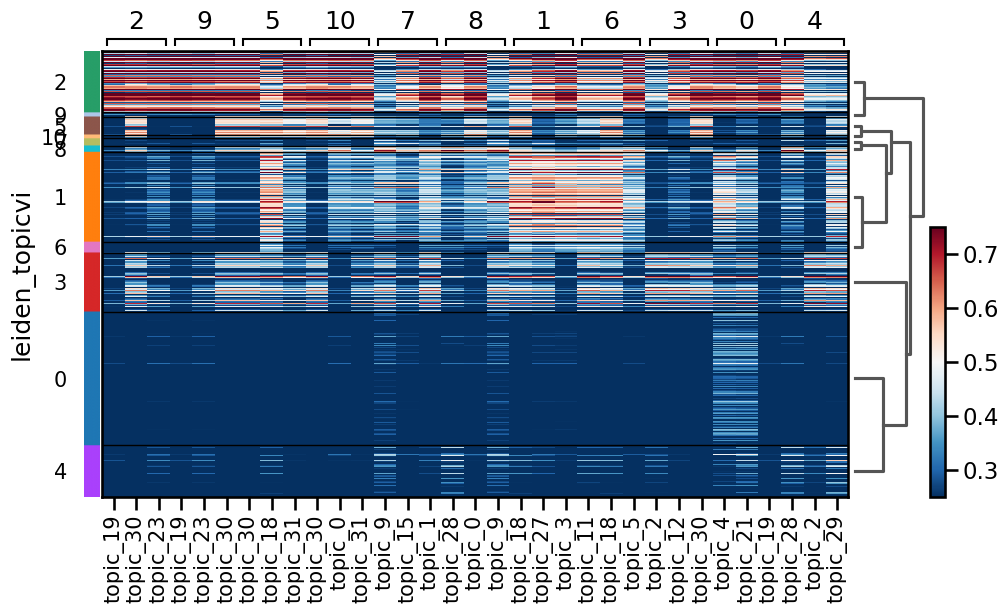

In [68]:
sc.tl.rank_genes_groups(fdata, groupby='leiden_topicvi',)
sc.pl.rank_genes_groups_heatmap(
    fdata, groupby='leiden_topicvi', n_genes=3, use_raw=False, cmap='RdBu_r',
    vmin=0.25, vmax=0.75
)

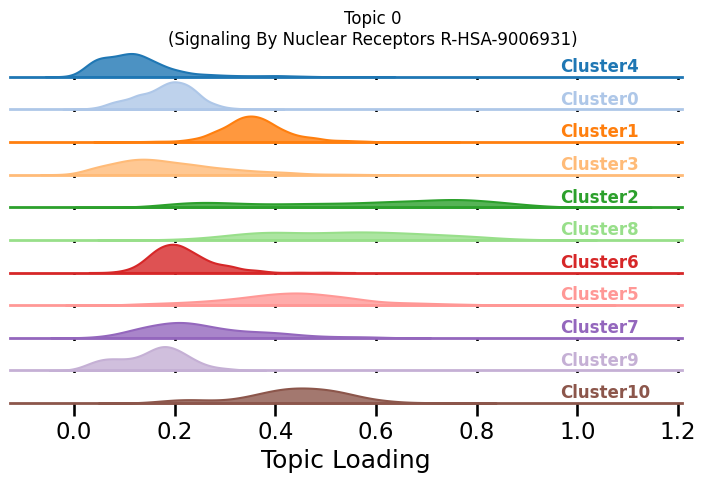

In [ ]:
tv.pl.ridge_topic_group(
    fdata, 
    groupby='leiden_topicvi', 
    target_topic=0, 
    topic_annote='Signaling By Nuclear Receptors R-HSA-9006931'
)